In [1]:
import numpy as np # linear algebra
import pandas as pd
import geopandas as gpd
import zipfile
import sklearn
import warnings
import json
warnings.filterwarnings('ignore')

from datetime import datetime

import statsmodels.api as sm

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.inspection import permutation_importance

se si vuole caricare solo la tabella finale unificata

In [2]:
trans_final = pd.read_pickle('./trans_final.pkl')
trans_final.head()

,id_trans,client_id_trans,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,mcc,day,...,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,years_to_retire,debt_to_income
0,7475327,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,5499,2010-01-01,...,594 Mountain View Street,46.80,-100.76,23679.0,48277.0,110153.0,740,4,37,2.281687
1,7475328,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,5311,2010-01-01,...,604 Pine Street,40.80,-91.12,18076.0,36853.0,112139.0,834,5,19,3.042873
2,7475329,1129,102,80.00,Swipe Transaction,27092,Vista,CA,4829,2010-01-01,...,2379 Forest Lane,33.18,-117.29,16894.0,34449.0,36540.0,686,3,16,1.060698
3,7475331,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,4829,2010-01-01,...,903 Hill Boulevard,41.42,-87.35,26168.0,53350.0,128676.0,685,5,15,2.411921
4,7475332,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,5813,2010-01-01,...,166 River Drive,38.86,-76.60,33529.0,68362.0,96182.0,711,2,18,1.406951


In [115]:
trans_final.columns

Index(['id_trans', 'client_id_trans', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'mcc', 'day', 'time',
       'fraud', 'client_id_card', 'card_brand', 'card_type', 'expires',
       'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'card_valid_month', 'id', 'current_age',
       'retirement_age', 'birth_year', 'gender', 'address', 'latitude',
       'longitude', 'per_capita_income', 'yearly_income', 'total_debt',
       'credit_score', 'num_credit_cards', 'years_to_retire',
       'debt_to_income'],
      dtype='object')

Estrazione delle tabelle e visualizzazione della corretta estrazione

In [3]:
with zipfile.ZipFile('./archive.zip', 'r') as zip_ref:
  with zip_ref.open('transactions_data.csv') as f:
        trans = pd.read_csv(f)
  with zip_ref.open('users_data.csv') as f:
        users = pd.read_csv(f)
  with zip_ref.open('cards_data.csv') as f:
        cards = pd.read_csv(f)


In [4]:
trans.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [5]:
cards.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [119]:
users.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


Informazioni riguardanti il dataset

In [120]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          object 
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.2+ GB


Converto il campo amount in float32 togliendo il valore del dollaro e faccio il cast a stringa per il campo zip, successivamente si scompone la colonna date che è in formato datetime in date e time

In [6]:
trans.replace(r"['$']", '', regex = True, inplace=True)
trans['amount'] = trans['amount'].astype('float32')
trans['day'] = pd.to_datetime(trans['date']).dt.date
trans['time'] = pd.to_datetime(trans['date']).dt.time

Rilevamento valori NaN nella tabella trans

In [122]:
trans.isna().sum(axis=0)

id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
day                      0
time                     0
dtype: int64

I valori NaN nei campi merchant_city e zip possono essere dati dal fatto che sono negozi online. Riempiamo quei campi con ONLINE quando merchant_city è ONLINE. Si ignorano i campi NaN dello zip poiché non verrà utilizzato nelle successive analisi.

In [7]:
trans.loc[ trans['merchant_city'].str.upper() =='ONLINE','merchant_state'] = "ONLINE"

In [124]:
trans.isna().sum(axis=0)

id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state           0
zip                1652706
mcc                      0
errors            13094522
day                      0
time                     0
dtype: int64

In [125]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          float32
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
 12  day             object 
 13  time            object 
dtypes: float32(1), float64(1), int64(5), object(7)
memory usage: 1.3+ GB


Eliminazione delle colonne che non sono di interesse

In [8]:
trans.drop(['date', 'zip','errors'], axis=1, inplace=True)

In [127]:
trans.head()

,id,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,mcc,day,time
0,7475327,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,5499,2010-01-01,00:01:00
1,7475328,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,5311,2010-01-01,00:02:00
2,7475329,1129,102,80.00,Swipe Transaction,27092,Vista,CA,4829,2010-01-01,00:02:00
3,7475331,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,4829,2010-01-01,00:05:00
4,7475332,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,5813,2010-01-01,00:06:00


informazioni riguardanti cards_data

In [128]:
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     6146 non-null   int64 
 1   client_id              6146 non-null   int64 
 2   card_brand             6146 non-null   object
 3   card_type              6146 non-null   object
 4   card_number            6146 non-null   int64 
 5   expires                6146 non-null   object
 6   cvv                    6146 non-null   int64 
 7   has_chip               6146 non-null   object
 8   num_cards_issued       6146 non-null   int64 
 9   credit_limit           6146 non-null   object
 10  acct_open_date         6146 non-null   object
 11  year_pin_last_changed  6146 non-null   int64 
 12  card_on_dark_web       6146 non-null   object
dtypes: int64(6), object(7)
memory usage: 624.3+ KB


In [9]:
cards['expires'] = pd.to_datetime(cards['expires'], format = "%m/%Y")
cards['acct_open_date'] = pd.to_datetime(cards['acct_open_date'], format = "%m/%Y")
cards['card_valid_month'] = (cards['expires'].dt.year- cards['acct_open_date'].dt.year)*12 + (cards['expires'].dt.month - cards['acct_open_date'].dt.month)

si fa diventare il campo credit limit un float eliminando il simbolo del dollaro


In [10]:
cards['credit_limit'] = (cards['credit_limit'].replace(r"['$']",'',regex= True)).astype('float32')

rilevamento valori NaN nella tabella cards_data

In [131]:
cards.isna().sum(axis=0)

id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
card_valid_month         0
dtype: int64

In [132]:
cards.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,card_valid_month
0,4524,825,Visa,Debit,4344676511950444,2022-12-01,623,YES,2,24295.0,2002-09-01,2008,No,243
1,2731,825,Visa,Debit,4956965974959986,2020-12-01,393,YES,2,21968.0,2014-04-01,2014,No,80
2,3701,825,Visa,Debit,4582313478255491,2024-02-01,719,YES,2,46414.0,2003-07-01,2004,No,247
3,42,825,Visa,Credit,4879494103069057,2024-08-01,693,NO,1,12400.0,2003-01-01,2012,No,259
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,2009-03-01,75,YES,1,28.0,2008-09-01,2009,No,6


informazioni riguardanti trans_final

In [133]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   object 
 6   address            2000 non-null   object 
 7   latitude           2000 non-null   float64
 8   longitude          2000 non-null   float64
 9   per_capita_income  2000 non-null   object 
 10  yearly_income      2000 non-null   object 
 11  total_debt         2000 non-null   object 
 12  credit_score       2000 non-null   int64  
 13  num_credit_cards   2000 non-null   int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 218.9+ KB


rilevamenti valori NaN nella tabella trans_final

In [134]:
users.isna().sum(axis=0)

id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64

converto i campi per_capita_income, yearly_income e totale_dept in float32 e rimuovo da essi il simbolo del dollaro.

In [11]:
users = users.replace(r"['$']", '', regex = True)
users['per_capita_income'] = users['per_capita_income'].astype('float32')
users['yearly_income'] = users['yearly_income'].astype('float32')
users['total_debt'] = users['total_debt'].astype('float32')

calcolo degli anni per andare in pensione, se già in pensione valore 0


In [12]:
users['years_to_retire'] = np.where(users['retirement_age'] >= users['current_age'],
                                    users['retirement_age'] - users['current_age'],0 )

In [137]:
users.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,years_to_retire
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5,13
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,37891.0,77254.0,191349.0,701,5,15
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,22681.0,33483.0,196.0,698,5,0
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,163145.0,249925.0,202328.0,722,4,0
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,53797.0,109687.0,183855.0,675,1,27


apro e analizzo il file json

In [13]:
with zipfile.ZipFile('./archive.zip', 'r') as zip_ref:
  with zip_ref.open('train_fraud_labels.json') as f:
        fraud_users = pd.read_json(f)

visualizzo la struttura del file

In [139]:
fraud_users.head()

,target
10649266,No
23410063,No
9316588,No
12478022,No
9558530,No


controllo se ci sono falori nulli

In [140]:
fraud_users.isna().sum()

target    0
dtype: int64

cambio i valori 'No' in 0 e i valori 'Yes' in 1 per poter andare ad utilizzare questo campo nelle successive analisi

In [14]:
fraud_users['fraud'] = [0 if item == 'No' else 1 for item in fraud_users['target']]

 modifico il file potermi poi connettere alla tabella delle transazioni

In [15]:
fraud_users.drop('target',axis=1, inplace=True)
fraud_users.reset_index(inplace=True)

struttura finale

In [143]:
fraud_users.head()

,index,fraud
0,10649266,0
1,23410063,0
2,9316588,0
3,12478022,0
4,9558530,0


Inizio Data Visualization

Unificazione delle tabelle

In [16]:
## join delle tabelle trans e fraud
trans_final = pd.merge(trans, fraud_users, left_on='id',right_on = 'index', how = 'left')
trans.shape
cards.columns
## join tabella trans + fraud e cards
trans_final = pd.merge(trans_final, cards.drop(['card_number','cvv','card_on_dark_web'],axis=1), left_on='card_id', right_on = 'id', how= 'left',suffixes = ("_trans","_card"))
trans_final.shape
## eliminazione delle colonne indici
trans_final.drop(['index','id_card'], axis=1, inplace=True)

join con users e salvataggio tabella come pickle

In [17]:
trans_final = pd.merge(trans_final, users.drop('birth_month',axis=1),left_on='client_id_trans', right_on = 'id', how= 'left',suffixes = ("_trans","_user"))


In [18]:
with zipfile.ZipFile('./archive.zip', 'r') as zip_ref:
    with zip_ref.open('mcc_codes.json') as f:
        mcc_dict = json.load(f) 
    
mcc_df = pd.DataFrame.from_dict(
    mcc_dict,
    orient='index',            # le chiavi del dict diventano l'indice
    columns=['description']    # la colonna dei valori si chiama 'description'
).reset_index().rename(columns={'index': 'mcc_code'})

print(mcc_df.head())


  mcc_code                           description
0     5812         Eating Places and Restaurants
1     5541                      Service Stations
2     7996  Amusement Parks, Carnivals, Circuses
3     5411          Grocery Stores, Supermarkets
4     4784                 Tolls and Bridge Fees


In [19]:
mcc_df['mcc_code'] = mcc_df['mcc_code'].astype('int32')
mcc_df.head()

,mcc_code,description
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees


utilizzo map perché il merge era troppo costoso in termini di dimensioni per una tabella così grande

In [20]:
# 1) Crea un dict: codice → descrizione
mcc_map = dict(zip(mcc_df['mcc_code'], mcc_df['description']))

# 2) Aggiungi la colonna 'description' mappando su 'mcc'
trans_final['description'] = trans_final['mcc'].map(mcc_map)
trans_final.drop('mcc', axis=1, inplace=True)
trans_final.rename(columns={'description': 'mcc_description'}, inplace=True)

In [ ]:
trans_final.head(200)

,id_trans,client_id_trans,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,day,time,...,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,years_to_retire,debt_to_income,mcc_description
0,7475327,1556,2972,-77.000000,Swipe Transaction,59935,Beulah,ND,2010-01-01,00:01:00,...,46.80,-100.76,23679.0,48277.0,110153.0,740,4,37,2.281687,Miscellaneous Food Stores
1,7475328,561,4575,14.570000,Swipe Transaction,67570,Bettendorf,IA,2010-01-01,00:02:00,...,40.80,-91.12,18076.0,36853.0,112139.0,834,5,19,3.042873,Department Stores
2,7475329,1129,102,80.000000,Swipe Transaction,27092,Vista,CA,2010-01-01,00:02:00,...,33.18,-117.29,16894.0,34449.0,36540.0,686,3,16,1.060698,Money Transfer
3,7475331,430,2860,200.000000,Swipe Transaction,27092,Crown Point,IN,2010-01-01,00:05:00,...,41.42,-87.35,26168.0,53350.0,128676.0,685,5,15,2.411921,Money Transfer
4,7475332,848,3915,46.410000,Swipe Transaction,13051,Harwood,MD,2010-01-01,00:06:00,...,38.86,-76.60,33529.0,68362.0,96182.0,711,2,18,1.406951,Drinking Places (Alcoholic Beverages)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,7475547,1513,2965,1.000000,Swipe Transaction,86438,Dryden,NY,2010-01-01,05:46:00,...,41.30,-73.13,32240.0,65736.0,206000.0,733,3,18,3.133747,Miscellaneous Food Stores
196,7475548,1776,4938,11.910000,Swipe Transaction,73840,Nashport,OH,2010-01-01,05:46:00,...,40.04,-82.12,21156.0,43133.0,44263.0,693,3,28,1.026198,Drug Stores and Pharmacies
197,7475551,52,4976,115.820000,Swipe Transaction,26810,Plattekill,NY,2010-01-01,05:48:00,...,41.56,-73.59,31288.0,63796.0,82173.0,730,3,10,1.288059,Service Stations
198,7475552,246,1158,34.459999,Swipe Transaction,53187,Minneapolis,MN,2010-01-01,05:48:00,...,44.96,-93.26,40364.0,82298.0,0.0,791,4,20,0.000000,Drinking Places (Alcoholic Beverages)


In [22]:
trans_final.to_pickle('./trans_final.pkl')

frodi al giorno

(array([14245., 14610., 14975., 15340., 15706., 16071., 16436., 16801.,
        17167., 17532., 17897., 18262.]),
 [Text(14245.0, 0, '2009'),
  Text(14610.0, 0, '2010'),
  Text(14975.0, 0, '2011'),
  Text(15340.0, 0, '2012'),
  Text(15706.0, 0, '2013'),
  Text(16071.0, 0, '2014'),
  Text(16436.0, 0, '2015'),
  Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020')])

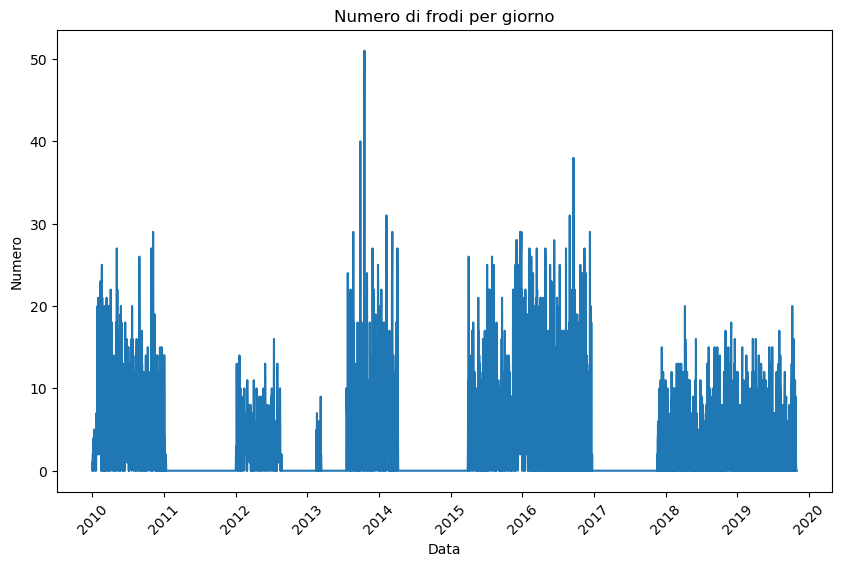

In [ ]:
fraud_by_day = trans_final.groupby('day')['fraud'].agg('sum')
plt.figure(figsize=(10, 6))
sns.lineplot(fraud_by_day)
plt.title('Numero di frodi per giorno')
plt.xlabel('Data')
plt.ylabel('Numero')
plt.xticks(rotation=45)

numero di frodi per intervallo di tempo


In [ ]:
def intervallo_temporale(ora):
    hour = ora.hour
    if 0 <= hour < 4:
        return 'Intervallo1 (00:00-03:59)'
    elif 4 <= hour < 8:
        return 'Intervallo2 (04:00-07:59)'
    elif 8 <= hour < 12:
        return 'Intervallo3 (08:00-11:59)'
    elif 12 <= hour < 16:
        return 'Intervallo4 (12:00-15:59)'
    elif 16 <= hour < 20:
        return 'Intervallo5 (16:00-19:59)'
    elif 20 <= hour < 24:
        return 'Intervallo6 (20:00-23:59)'

# Applicare la funzione sulla colonna 'time' e creare una nuova colonna 'intervallo'
trans_final['intervallo_temporale'] = trans_final['time'].apply(intervallo_temporale)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Intervallo1 (00:00-03:59)'),
  Text(1, 0, 'Intervallo2 (04:00-07:59)'),
  Text(2, 0, 'Intervallo3 (08:00-11:59)'),
  Text(3, 0, 'Intervallo4 (12:00-15:59)'),
  Text(4, 0, 'Intervallo5 (16:00-19:59)'),
  Text(5, 0, 'Intervallo6 (20:00-23:59)')])

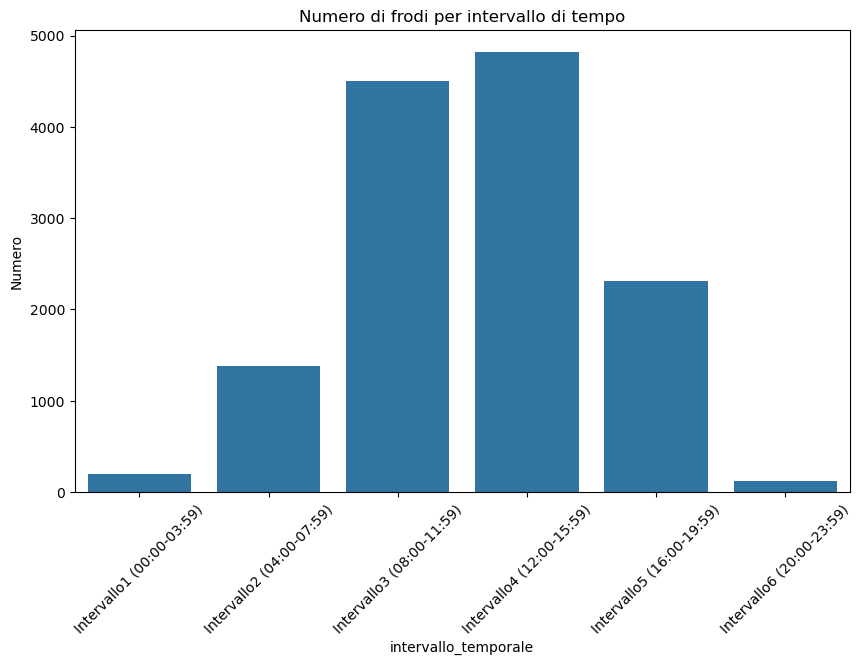

In [ ]:
trans_final['year'] = pd.to_datetime(trans_final['day']).dt.year
trans_final['month'] = pd.to_datetime(trans_final['day']).dt.month
trans_final.shape
fraud_by_tid = trans_final.groupby('intervallo_temporale')['fraud'].agg('sum')

plt.figure(figsize=(10, 6))
sns.barplot(x=pd.DataFrame(fraud_by_tid).index, y= 'fraud', data=pd.DataFrame(fraud_by_tid))
plt.title('Numero di frodi per intervallo di tempo')
plt.ylabel('Numero')
plt.xticks(rotation=45)

tasso di frodi per intervallo di tempo (non ho capito bene che cambia da sopra, in caso sia importante da fare anche per i tipi di attività colpite da frodi)

In [ ]:
fraud_by_int_mean = trans_final.groupby('intervallo_temporale')['fraud'].agg('mean')*100

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Intervallo1 (00:00-03:59)'),
  Text(1, 0, 'Intervallo2 (04:00-07:59)'),
  Text(2, 0, 'Intervallo3 (08:00-11:59)'),
  Text(3, 0, 'Intervallo4 (12:00-15:59)'),
  Text(4, 0, 'Intervallo5 (16:00-19:59)'),
  Text(5, 0, 'Intervallo6 (20:00-23:59)')])

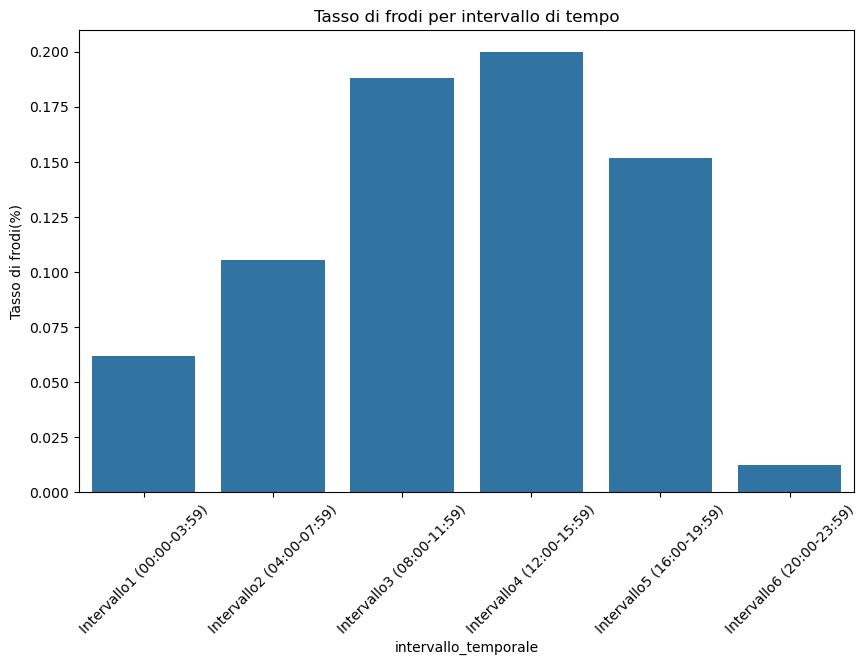

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=pd.DataFrame(fraud_by_int_mean).index, y= 'fraud', data=pd.DataFrame(fraud_by_int_mean))
plt.title('Tasso di frodi per intervallo di tempo')
plt.ylabel('Tasso di frodi(%)')
plt.xticks(rotation=45)

tasso di frodi al mese

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

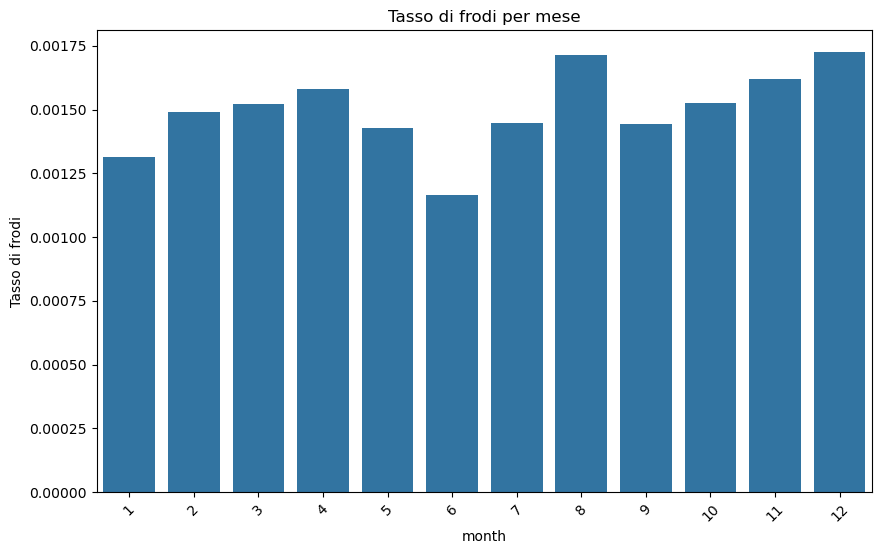

In [ ]:
fraud_by_month = trans_final.groupby('month')['fraud'].agg('mean')

plt.figure(figsize=(10, 6))
sns.barplot(x=pd.DataFrame(fraud_by_month).index, y= 'fraud', data=pd.DataFrame(fraud_by_month))
plt.title('Tasso di frodi per mese')
plt.ylabel('Tasso di frodi')
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Distribuzione geografica di tutte le frodi')

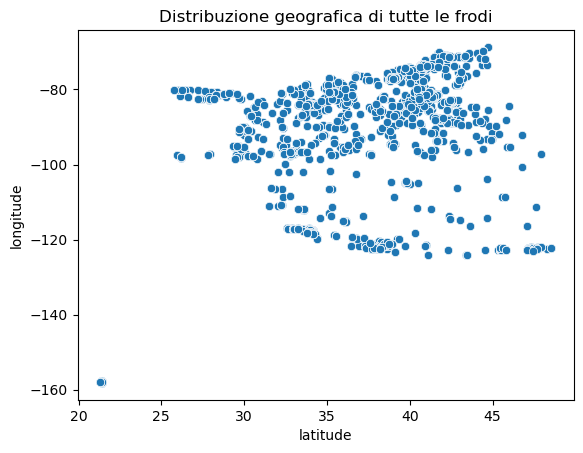

In [ ]:
trans_fraud = trans_final.loc[trans_final['fraud']==1,:]
sns.scatterplot(x ='latitude', y='longitude', data = trans_fraud)
plt.title("Distribuzione geografica di tutte le frodi")

tipologie di attività commerciali colpite da frodi

Text(0, 0.5, 'Tipo di attività')

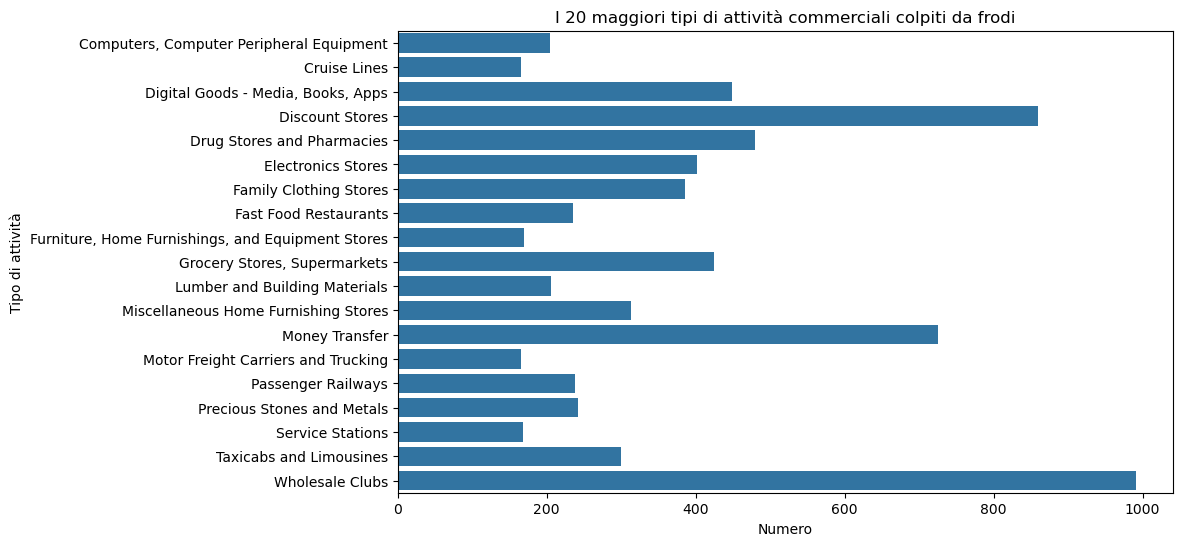

In [75]:
fraud_by_mcc = trans_final.groupby('mcc_description')['fraud'].agg('sum').sort_values(ascending = False)
fraud_by_mcc_20 = pd.DataFrame({'tasso': fraud_by_mcc[1:20], 'tipo': fraud_by_mcc[1:20].index.astype("category")})

plt.figure(figsize=(10, 6))
sns.barplot(data=fraud_by_mcc_20, y = 'tipo',x='tasso' )
plt.title('I 20 maggiori tipi di attività commerciali colpiti da frodi')
plt.xlabel('Numero')
plt.ylabel('Tipo di attività')

che rappresenta??? la variabile è scritta in svedese? :(

Text(0.5, 1.0, 'Istogramma per gli importi degli acquisti')

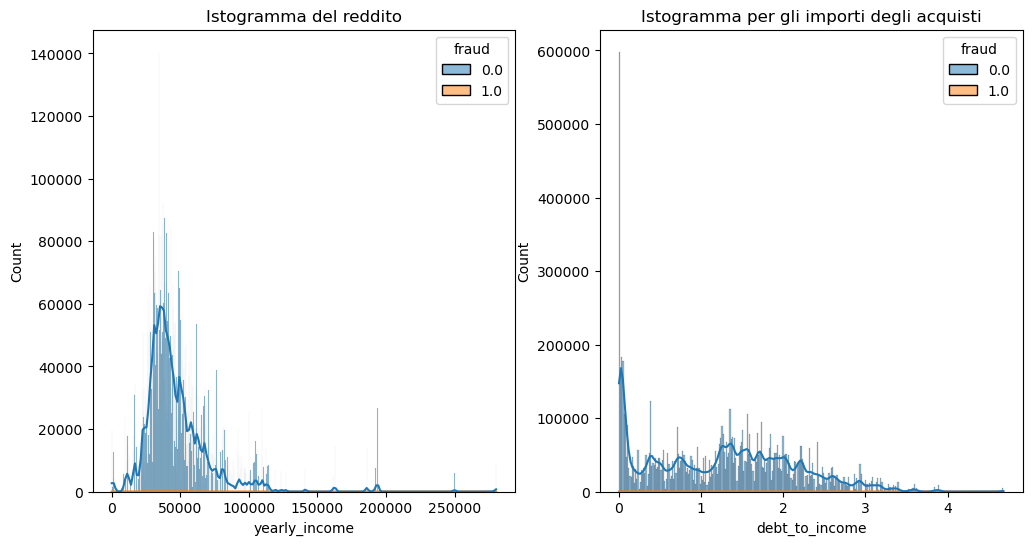

In [ ]:
socio_eko_hue = trans_final.groupby('fraud')[['current_age','yearly_income','debt_to_income']].agg(['mean','std'])
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(trans_final, x='yearly_income', kde=True, hue = 'fraud', ax=axes[0])
axes[0].set_title('Istogramma del reddito')
sns.histplot(trans_final, x='debt_to_income', kde=True, hue = 'fraud', ax=axes[1])
axes[1].set_title('Istogramma per gli importi degli acquisti')

circuiti delle carte


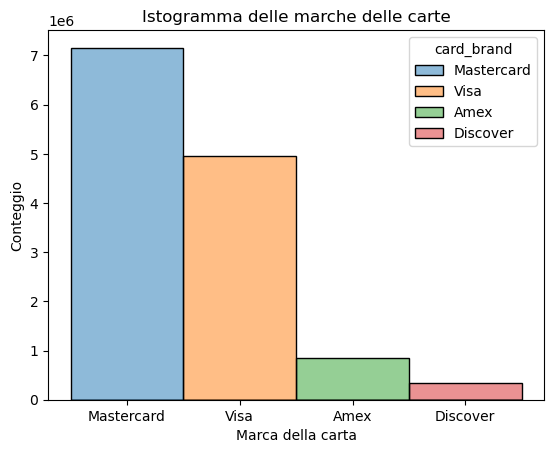

In [ ]:

sns.histplot(data=trans_final, x='card_brand', hue='card_brand')

# Add title
plt.title("Istogramma dei circuiti delle carte")
plt.xlabel("Circuito della carta")
plt.ylabel("Conteggio")
plt.show()


distribuzione uomini/donne nel dataset

In [ ]:
gender_count = users['gender'].value_counts()
print(gender_count)

gender
Female    1016
Male       984
Name: count, dtype: int64


transazioni effettuate da uomini e donne

In [76]:
gender_count = trans_final['gender'].value_counts()
print(gender_count)

gender
Female    6815916
Male      6489999
Name: count, dtype: int64


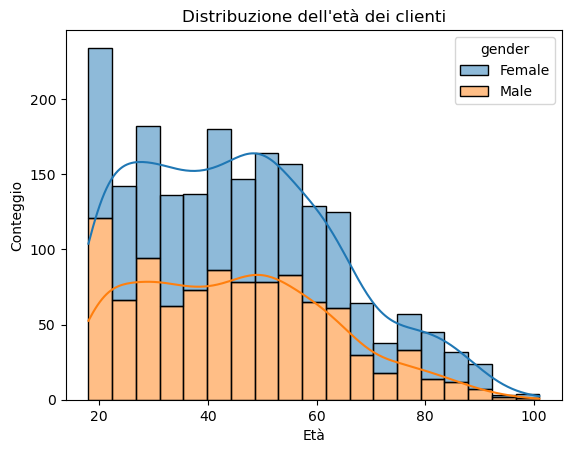

In [77]:
sns.histplot(data = users, x = 'current_age', hue = 'gender', multiple = 'stack', kde = True)
plt.title('Distribuzione dell\'età dei clienti')
plt.xlabel('Età')
plt.ylabel('Conteggio')
plt.show()


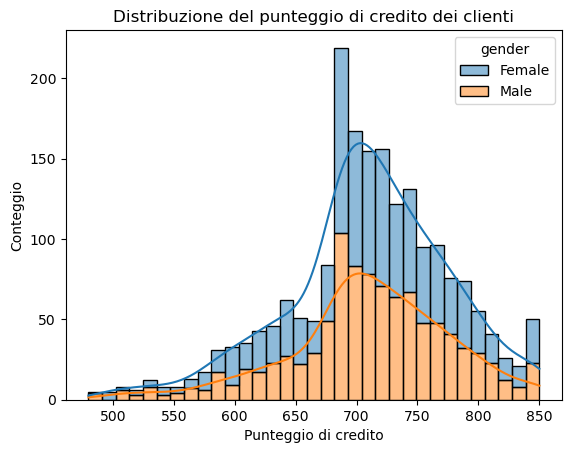

In [ ]:
sns.histplot(data = users, x = 'credit_score', hue = 'gender', multiple = 'stack', kde = True)
plt.title('Distribuzione del credit score dei clienti')
plt.xlabel('Punteggio di credito')
plt.ylabel('Conteggio')
plt.show()

Un credit score (punteggio di credito) viene solitamente calcolato da agenzie di credito utilizzando modelli che assegnano un punteggio numerico, basato sulla tua storia finanziaria e su vari fattori, come i pagamenti, i debiti, la durata della tua storia creditizia, ecc.

Punteggio Inferiore a 580:

Molto basso: Questo punteggio indica una gestione del credito non ottimale, con probabilità di incorrere in difficoltà nel pagare i debiti.

Le persone con punteggi così bassi potrebbero avere difficoltà ad accedere a prestiti o carte di credito, o potrebbero affrontare tassi di interesse molto alti.

580 - 669:

Adeguato: Punteggio inferiore alla media, ma non così basso da escludere l'accesso a prestiti o carte di credito.

Potresti ancora essere in grado di ottenere credito, ma con tassi di interesse più alti rispetto a chi ha un punteggio di credito migliore.

670 - 739:

Buono: Questo è un punteggio di credito nella media. Le persone con punteggi in questa fascia hanno probabilità di ricevere condizioni di credito favorevoli, ma non sono considerati eccellenti.

È un buon punteggio per ottenere prestiti o carte di credito con tassi di interesse moderati.

740 - 799:

Molto buono: Le persone con questo punteggio hanno una storia di credito solida e sono generalmente considerate a basso rischio per le istituzioni finanziarie.

È facile ottenere credito con tassi di interesse favorevoli.

800 e oltre:

Eccellente: Questo è il punteggio più alto e indica una gestione impeccabile delle finanze e una lunga storia di pagamenti puntuali. Le persone con un punteggio in questa fascia possono ottenere i migliori tassi di interesse e sono viste come molto affidabili.

In [ ]:
import folium
import pandas as pd

# bins, labels e score_band come prima
bins   = [0, 579, 669, 739, 799, 999]
labels = ['Molto basso','Adeguato','Buono','Molto buono','Eccellente']

users['score_band'] = pd.cut(
    users['credit_score'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

# colori CSS per fascia
color_map = {
    'Molto basso':   'red',
    'Adeguato':      'orange',
    'Buono':         'yellow',
    'Molto buono':   'lightgreen',
    'Eccellente':    'green'
}

# centro mappa
center = [users['latitude'].mean(), users['longitude'].mean()]

# crea la mappa senza cluster
m = folium.Map(location=center, zoom_start=6, tiles='CartoDB positron')

# aggiungi ogni cerchio direttamente alla mappa
for _, row in users.iterrows():
    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        radius=4,
        color=color_map[row.score_band],
        fill=True, fill_opacity=0.6,
        popup=f"{row.score_band} ({row.credit_score})"
    ).add_to(m)

# mostra mappa (se in notebook basta mettere m alla fine della cella)
m


In [ ]:
trans_final.columns

Index(['id_trans', 'client_id_trans', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'mcc', 'day', 'time',
       'fraud', 'client_id_card', 'card_brand', 'card_type', 'expires',
       'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'card_valid_month', 'id', 'current_age',
       'retirement_age', 'birth_year', 'gender', 'address', 'latitude',
       'longitude', 'per_capita_income', 'yearly_income', 'total_debt',
       'credit_score', 'num_credit_cards', 'years_to_retire', 'debt_to_income',
       'intervallo_temporale', 'year', 'month'],
      dtype='object')

In [70]:
temp = cards.groupby('client_id').agg(total_credit_limit = ('credit_limit', 'sum'), total_cards = ('id', 'count'))
temp


,total_credit_limit,total_cards
client_id,,
0,105656.0,4
1,41805.0,3
2,50361.0,5
3,13722.0,4
4,136202.0,5
...,...,...
1995,30965.0,4
1996,47175.0,3
1997,142669.0,7


<Axes: xlabel='total_credit_limit', ylabel='Count'>

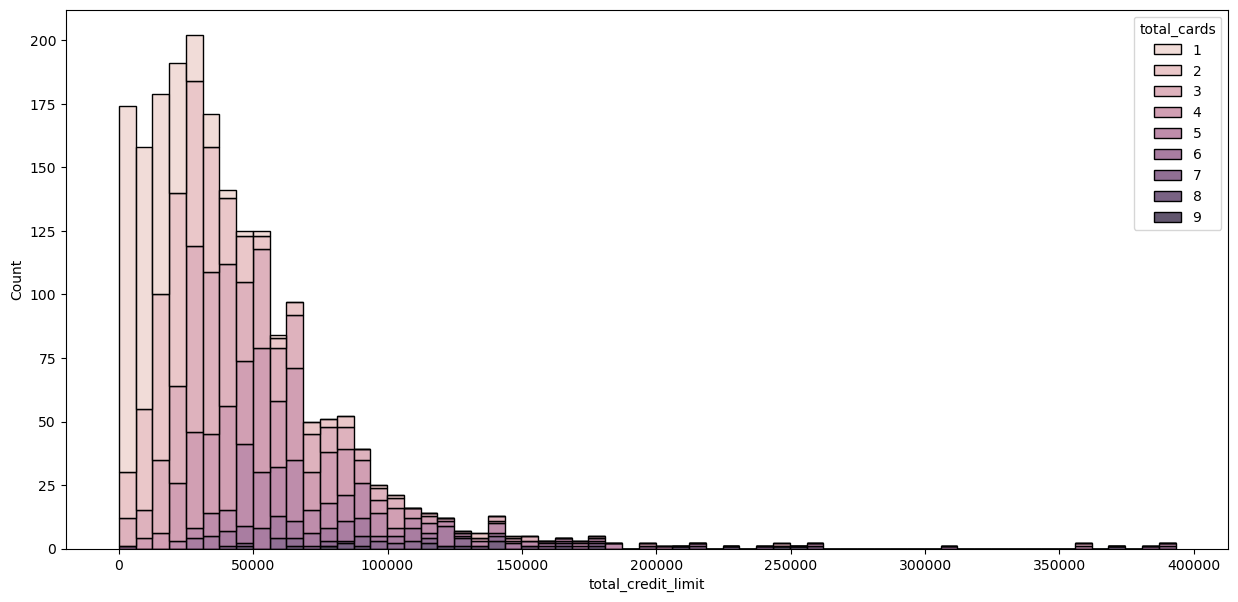

In [71]:
plt.figure(figsize = (15,7))
sns.histplot(data = temp, x  = 'total_credit_limit', hue = 'total_cards', multiple = 'stack')

conteggio del numero di carte presenti nel dark web

In [72]:
cards['card_on_dark_web'].value_counts()

card_on_dark_web
No    6146
Name: count, dtype: int64